## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Load image paths and explore dataset

In [25]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import glob
from skimage.feature import hog
from skimage import color, exposure
%matplotlib inline

# images are divided up into vehicles and non-vehicles
car_images_udacity = glob.glob(r'C:\Users\mohar\Desktop\Vinod\vehicles\*\*.png')
notcar_images_udacity = glob.glob(r'C:\Users\mohar\Desktop\Vinod\non-vehicles\*\*.png')

cars = []
notcars = []

for image in car_images_udacity:
    cars.append(image)

for image in notcar_images_udacity:
    notcars.append(image)

# Define a function that takes in rgb png/jpg img path and returns rgb with individuals pixel
# values between 0-255 and astype uint8
def read_jpg_png(img_path):
    # Read in a test image, cv2.imread reads in rgb and returns bgr from 0 - 255 with type uint8
    #  for both jpg and png images. This [...,::-1] last bit converts bgr to rgb
    return np.array(cv2.imread(img_path))[...,::-1]
    
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    test_img = read_jpg_png(car_list[np.random.randint(0, len(car_list))])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 4050  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


### Since the number of notcar images is more than car images we augment the car class using crowdai's dataset. The images from crowdai's dataset have been cropped as per bounding boxes and resized to (64, 64, 3). The processed images are stored in a folder called resized. This augmented car class after shuffling also helps in avoiding timeseries issues with the original data as will be observed later. The associated code can be found in Augment_dataset.ipynb

In [26]:
car_images_crowdai = glob.glob(r'C:\Users\mohar\Desktop\Vinod\resized\*.jpg')
# load image path randomly from resized images to augment car class
np.random.seed(0) # generate same indexes for crowd ai's database to avoid issues due to variation in training data later
for i in range(len(notcars) - len(cars)):
        cars.append(car_images_crowdai[np.random.randint(0, len(car_images_crowdai))])

### Verify that each class has equal number of training examples and shuffle arrays.

In [27]:
random.shuffle(cars) # shuffle paths contained in cars
random.shuffle(notcars) # shuffle paths contained in notcars
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 8968  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


### Helper functions

In [28]:
# Define a function to plot multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap = 'gray')
        else:
            plt.imshow(img)
        plt.title(titles[i])
        fig.subplots_adjust(hspace=.3)
        fig.subplots_adjust(wspace=.3)

In [29]:
# Define a function to perform histogram binning of image
def color_hist(img, nbins=32):    #bins_range=(0, 255)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [30]:
# Define a function to visualize color histogram features of individual channels
def vis_color_hist(img, nbins=32, bins_range=(0, 255)):
    # Compute the histogram of the all channels separately
    ch1hist = np.histogram(img[:,:,0], nbins, bins_range)
    ch2hist = np.histogram(img[:,:,1], nbins, bins_range)
    ch3hist = np.histogram(img[:,:,2], nbins, bins_range)
    # Generating bin centers
    bin_centers = (ch1hist[1][:-1] + ch1hist[1][1:])/2
    # Plot a figure with all three bar charts
    if ch1hist is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bin_centers, ch1hist[0])
        plt.xlim(0, 255)
        plt.title('Ch-1 Histogram')
        plt.subplot(132)
        plt.bar(bin_centers, ch2hist[0])
        plt.xlim(0, 255)
        plt.title('Ch-2 Histogram')
        plt.subplot(133)
        plt.bar(bin_centers, ch3hist[0])
        plt.xlim(0, 255)
        plt.title('Ch-3 Histogram')
        fig.tight_layout()
    else:
        print('Your function is returning None for at least one variable...')
    return None

In [31]:
# Define a function to extract HOG features from image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, blk_norm='L2-Hys',
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm=blk_norm,
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm=blk_norm,
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [32]:
# Define a function to perform spatial binning of an image
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [33]:
# Define a function to perform spatial binning of an image given the channels
def bin_spatial_ch(img, size=(32, 32), channels=(0,1,2)):
    features = []
    for channel in channels:
        features.extend(cv2.resize(img[:,:,channel], size).ravel())
    return features

In [34]:
# Define a function to transition between colorspaces
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [35]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = read_jpg_png(file) # read in jpg/png as uint8 from 0 - 255 in RGB
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [36]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis = False):    
    #1) Define an empty list to receive features and hog_img if vis = True
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features, hog_img = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_img
    else:
        return np.concatenate(img_features)

In [37]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    # img = img.astype(np.float32)/255 # no longer needed since all pixels are uint8 from 0-255 and RGB
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb') # scales individual pixels back to 0-255 with dtype = float32
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [38]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [39]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [40]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Visualize a few car and non-car images

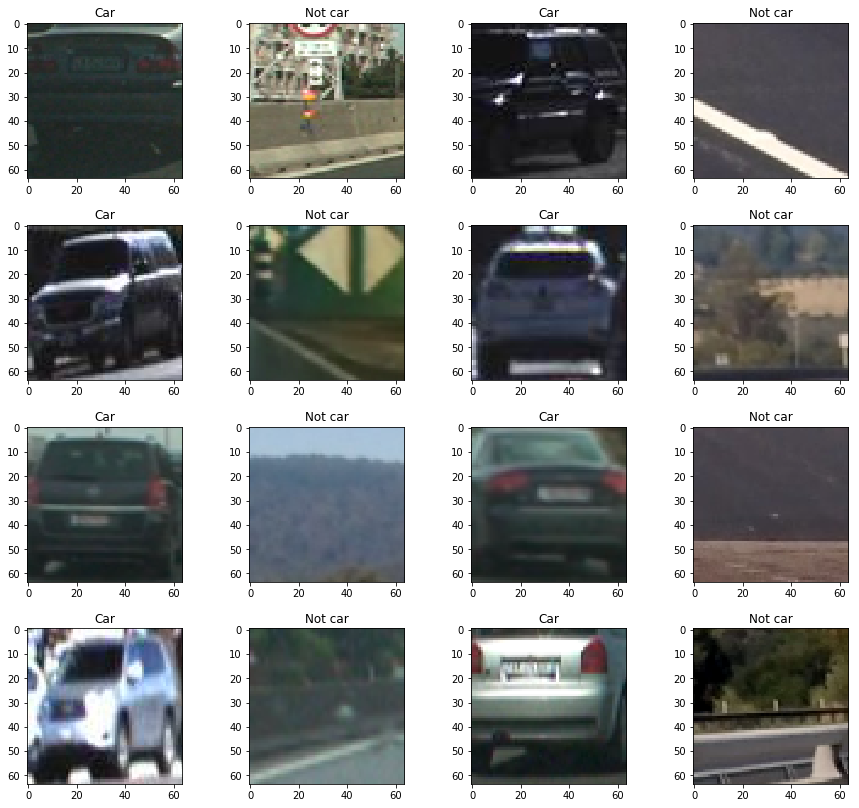

In [41]:
figure = plt.figure(figsize = (15,14))
imgs = []
for i in range(8):
    imgs.append(read_jpg_png(cars[np.random.randint(0, len(cars))]))
    imgs.append(read_jpg_png(notcars[np.random.randint(0, len(notcars))]))
titles = ['Car', 'Not car','Car', 'Not car','Car', 'Not car','Car', 'Not car',
         'Car', 'Not car','Car', 'Not car','Car', 'Not car','Car', 'Not car']
visualize(figure, 4, 4, imgs, titles)

### Read sample car and non-car images for colorspace and hog visualizations

In [42]:
# Choose indices for visualization
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# read in sample car and non-car image
car_img = read_jpg_png(cars[car_ind])
notcar_img = read_jpg_png(notcars[notcar_ind])

### Visualize colorspaces

RGB visualization


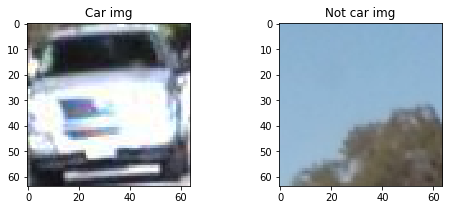

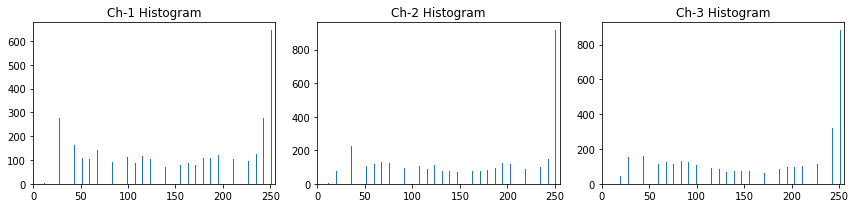

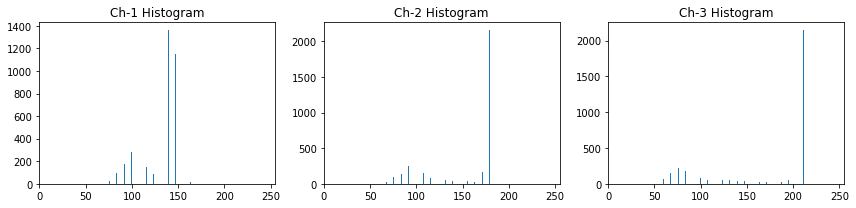

In [43]:
# RGB visualization
# plot car and notcar image in rgb for comparison with color histogram
figure = plt.figure(figsize=(8,3))
imgs = [car_img, notcar_img]
titles = ['Car img','Not car img']
visualize(figure, 1, 2, imgs, titles)
print('RGB visualization')

vis_color_hist(car_img, nbins=32, bins_range=(0, 255))
vis_color_hist(notcar_img, nbins=32, bins_range=(0, 255))

YCrCb visualization


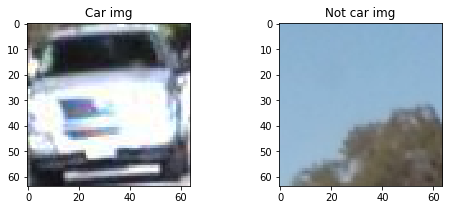

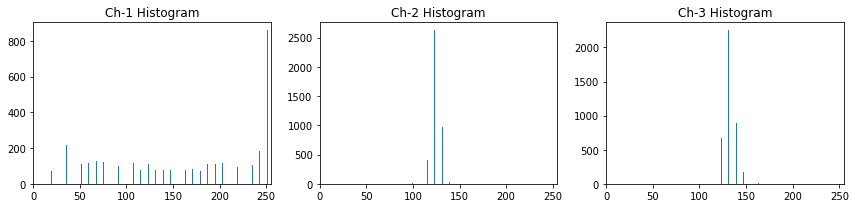

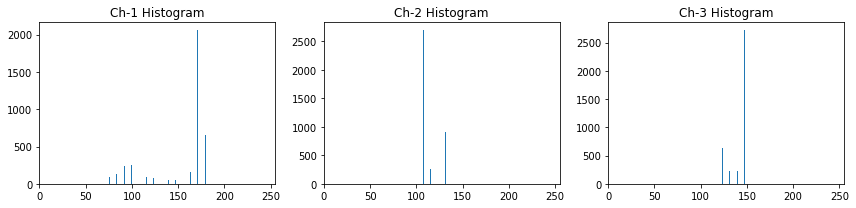

In [44]:
# YCrCb visualization
# plot car and notcar image in rgb for comparison with color histogram
figure = plt.figure(figsize=(8,3))
imgs = [car_img, notcar_img]
titles = ['Car img','Not car img']
visualize(figure, 1, 2, imgs, titles)
print('YCrCb visualization')
vis_color_hist(convert_color(car_img, conv='RGB2YCrCb'), nbins=32, bins_range=(0, 255))
vis_color_hist(convert_color(notcar_img, conv='RGB2YCrCb'), nbins=32, bins_range=(0, 255))

LUV visualization


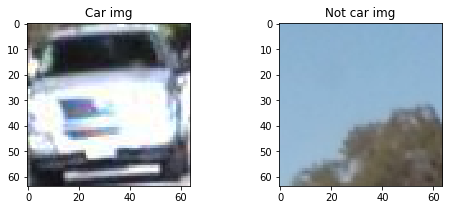

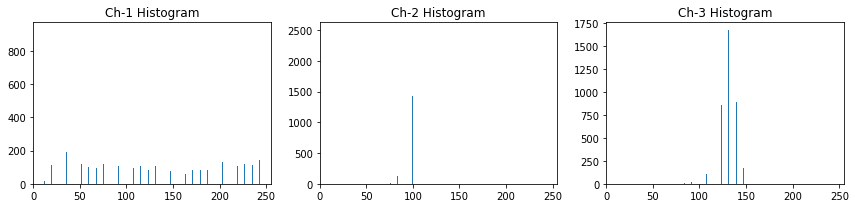

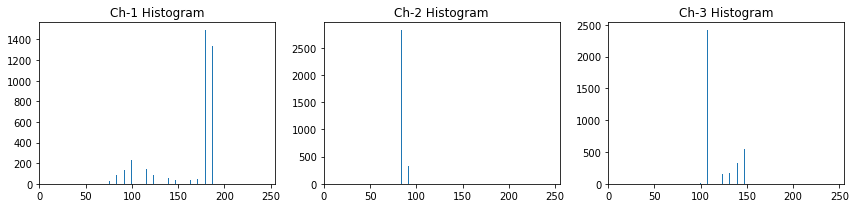

In [45]:
# LUV visualization
# plot car and notcar image in rgb for comparison with color histogram
figure = plt.figure(figsize=(8,3))
imgs = [car_img, notcar_img]
titles = ['Car img','Not car img']
visualize(figure, 1, 2, imgs, titles)
print('LUV visualization')
vis_color_hist(convert_color(car_img, conv='RGB2LUV'), nbins=32, bins_range=(0, 255))
vis_color_hist(convert_color(notcar_img, conv='RGB2LUV'), nbins=32, bins_range=(0, 255))

YUV visualization


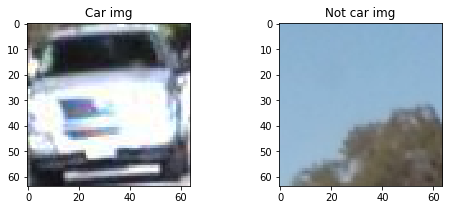

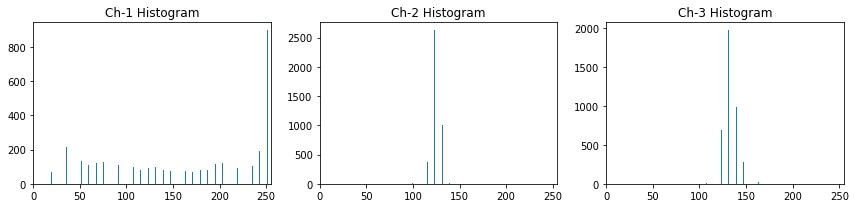

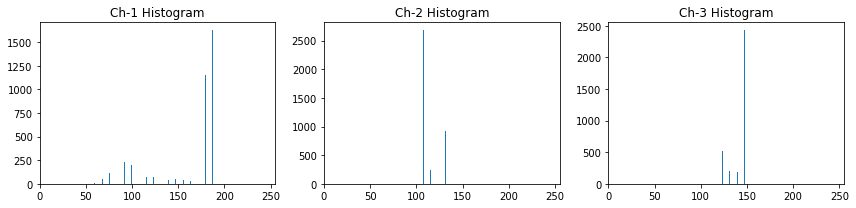

In [46]:
# YUV visualization
# plot car and notcar image in rgb for comparison with color histogram
figure = plt.figure(figsize=(8,3))
imgs = [car_img, notcar_img]
titles = ['Car img','Not car img']
visualize(figure, 1, 2, imgs, titles)
print('YUV visualization')
vis_color_hist(convert_color(car_img, conv='RGB2YUV'), nbins=32, bins_range=(0, 255))
vis_color_hist(convert_color(notcar_img, conv='RGB2YUV'), nbins=32, bins_range=(0, 255))

HSV visualization


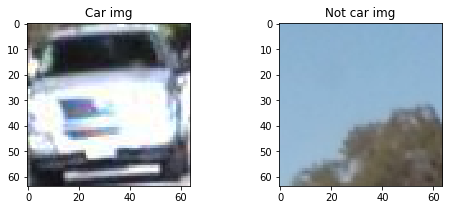

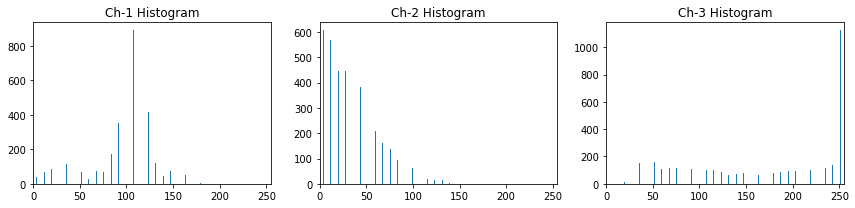

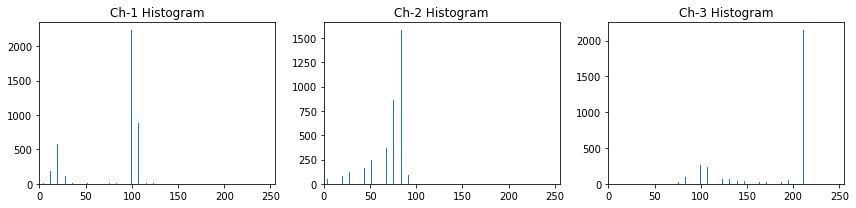

In [47]:
# HSV visualization
# plot car and notcar image in rgb for comparison with color histogram
figure = plt.figure(figsize=(8,3))
imgs = [car_img, notcar_img]
titles = ['Car img','Not car img']
visualize(figure, 1, 2, imgs, titles)
print('HSV visualization')
vis_color_hist(convert_color(car_img, conv='RGB2HSV'), nbins=32, bins_range=(0, 255))
vis_color_hist(convert_color(notcar_img, conv='RGB2HSV'), nbins=32, bins_range=(0, 255))

### Visualize HOG features

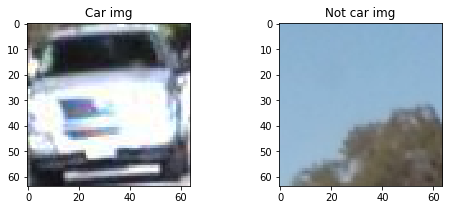

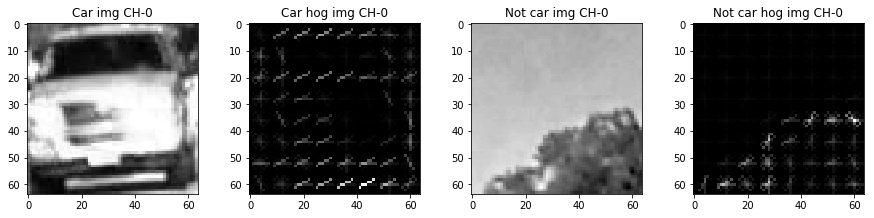

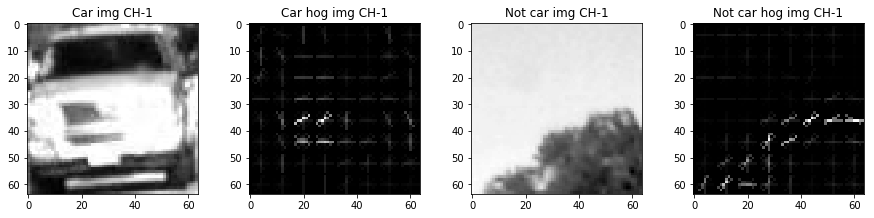

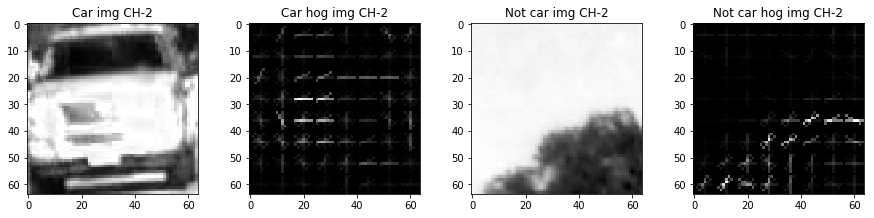

In [48]:
# Model parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32 # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

visualize_hog = [0, 1, 2]
# plot car and notcar image in rgb for comparison with extracted hog features
figure = plt.figure(figsize=(8,3))
imgs = [car_img, notcar_img]
titles = ['Car img','Not car img']
visualize(figure, 1, 2, imgs, titles)
    
for channel in visualize_hog:
    car_features, car_hog_img = single_img_features(car_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

    notcar_features, notcar_hog_img = single_img_features(notcar_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
    
    figure = plt.figure(figsize=(15,7))
    imgs = [car_img[:,:,channel], car_hog_img, notcar_img[:,:,channel], notcar_hog_img]   
    titles = ['Car img CH-' + str(channel), 'Car hog img CH-' + str(channel), 
              'Not car img CH-' + str(channel), 'Not car hog img CH-' + str(channel)]
    visualize(figure, 1, 4, imgs, titles)

### Building a classifier using linear support vector machine (svm)